In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import pad
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from tqdm import tqdm
from glob import glob

# Load model

## Architecture

In [2]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_kernel_size=None):
        super(CNNBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=True)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((pool_kernel_size, pool_kernel_size)) if pool_kernel_size is not None else nn.Identity()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class IRAA(nn.Module):
    def __init__(self, n_classes=1, dropout=0.05, pool_kernel_size=None, average_pool_size=1):
        super().__init__()
        self.encoder = nn.Sequential(
            CNNBlock(3, 64, pool_kernel_size=pool_kernel_size),
            nn.Dropout2d(dropout),
            CNNBlock(64, 32, pool_kernel_size=pool_kernel_size),
            nn.Dropout2d(dropout),
            CNNBlock(32, 16, pool_kernel_size=pool_kernel_size),
            nn.AdaptiveAvgPool2d((average_pool_size, average_pool_size)),
        )
        self.flatten = nn.Flatten()
        self.decoder = nn.Sequential(
            nn.Linear(16 * average_pool_size * average_pool_size, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.decoder(x)
        return x * 3

## Load weights

In [34]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
path_to_model_weights = '../data/weights/iraa.pt'

In [35]:
model = IRAA(pool_kernel_size=3, average_pool_size=3, dropout=0.1)
checkpoint = torch.load(path_to_model_weights, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [22]:
model.eval();

# Load data

In [ ]:
simple_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
])

def collate_padding(batch):
    max_h = max([b.shape[1] for b in batch])
    max_w = max([b.shape[2] for b in batch])
    h = 2 ** math.ceil(np.log2(max_h))
    w = 2 ** math.ceil(np.log2(max_w))
    imgs = torch.zeros(len(batch), 3, h, w)
    for i, im in enumerate(batch):
        new_w = int((w - im.shape[2]) / 2)
        new_h = int((h - im.shape[1]) / 2)
        imgs[i] = pad(im, pad=(new_w, w - new_w - im.shape[2], new_h, h - new_h - im.shape[1]), value=0)
    return imgs

class ImageGainDataset(Dataset):
    def __init__(self, images: list, transforms=None):
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        filename = self.images[idx]
        image = Image.open(filename).convert('RGB')
        
        image_np = np.array(image)
        if len(image_np.shape) == 2:
            image_np = image_np[:, :, None]
            image_np = np.concatenate((image_np, image_np, image_np), axis=2)
            image = Image.fromarray(image_np)            
        
        if self.transforms:
            image = self.transforms(image)
        return image
    
def predict(model, dataloader, device):
    model.to(device)
    model.eval()
    all_scores = []
    with torch.no_grad():
        for batch_images in tqdm(dataloader, total=len(dataloader), desc="eval"):
            scores = model(batch_images.to(device)).detach().cpu()
            all_scores.extend(scores.numpy())
    return np.array(all_scores).flatten()

In [24]:
path_to_imgs = '../data/train2017_coco_examples'
images = glob(f"{path_to_imgs}/*")
print(f"Number of examples: {len(images)}")

Number of examples: 22


In [25]:
batch_size = 2
dataset = ImageGainDataset(images, transforms=simple_transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=collate_padding)
len(dataset)

22

# Apply model

In [61]:
score_of_image = model(dataset[0][None, :])[0][0].item()
print(f"Score of one image: {score_of_image:.4f}")

Score of one image: 0.7021


In [27]:
scores = predict(model, dataloader, device)
print(np.mean(scores))

eval: 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]


1.8409942

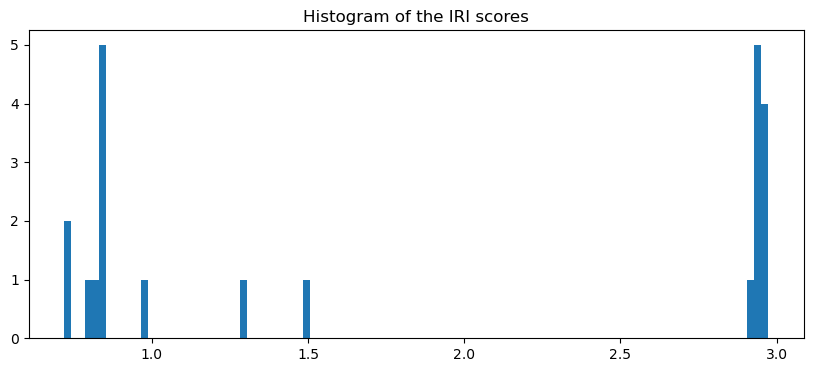

In [31]:
plt.figure(figsize=(10, 4))
plt.hist(scores, bins=100)
plt.title('Histogram of the IRI scores')
plt.show()

# Datasets robustness

In [172]:
path_to_datasets = '../data/dataset_robustness'
files = sorted(glob(f"{path_to_datasets}/*.npy"))
for file in files:
    with open(file, 'rb') as f:
        scores = np.load(f)
        mean_score = np.mean(scores)
    print(f"{file.split('/')[-1].split('.npy')[0]}: {mean_score:.3f}")

CID2013: 2.488
DIV2K: 1.952
KADID_10k: 1.834
LIVE_in_the_WILD: 2.428
MS_COCO_test2017: 1.808
NIPS2017: 1.648
PIPAL: 2.120
TID2013: 2.160
